In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle

In [2]:
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        if mfccs.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [ ]:
data = []
labels = []

base_dir = 'data/Audio_Data'
for label_name in ['Real', 'Fake']:
    label_dir = os.path.join(base_dir, label_name)
    for file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, file)
        features = extract_features(file_path)
        if features is not None:
            data.append(features)
            labels.append(0 if label_name == 'Real' else 1)


C:\Users\aky\AppData\Local\Temp\ipykernel_5032\2832786609.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=None)
C:\Users\aky\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing Dataset/Fake\file5323.mp3: 
Error processing Dataset/Fake\file9875.mp3: 


In [11]:
X=np.array(data)
y=np.array(labels)

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=43)

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [15]:
from sklearn.metrics import classification_report
ypre=rfc.predict(X_test)

In [16]:
print(classification_report(ypre,y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1007
           1       0.97      0.98      0.98      1016

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



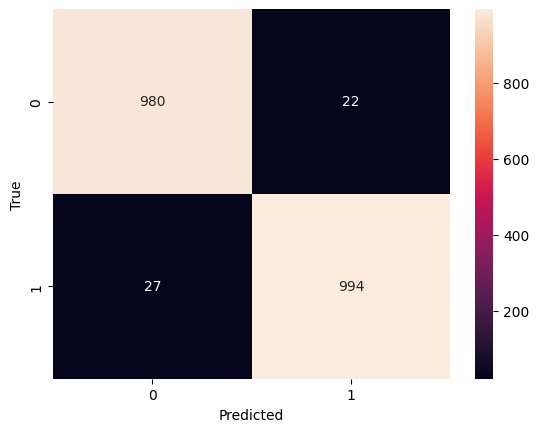

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, ypre)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [21]:
def predict_audio(file_path):
    features = extract_features(file_path)
    if features is not None:
        features = features.reshape(1, -1)
        prediction = rfc.predict(features)
        return "Real Voice" if prediction[0] == 0 else "Fake Voice"
    return "Could not process audio"

In [23]:
# Example
print(predict_audio('Dataset/Sample/file3405.mp3'))

Fake Voice


In [24]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc, X,y, cv=5)
print("Cross-Validation Accuracy:", scores.mean())

Cross-Validation Accuracy: 0.9770615664663491


In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr=LogisticRegression()

In [27]:
lr.fit(X_train,y_train)
ypre=lr.predict(X_test)

C:\Users\aky\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


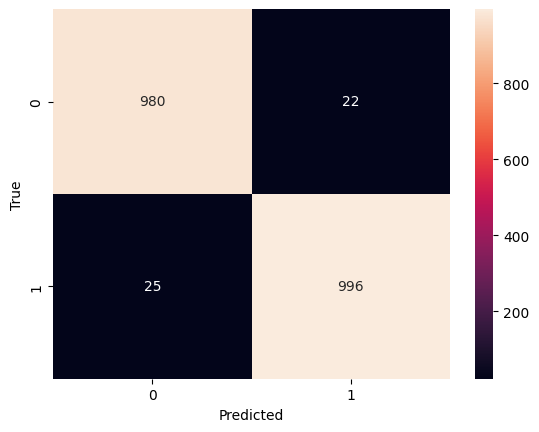

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, ypre)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [31]:
import pickle
with open('lr.pkl','wb') as f:
    pickle.dump(lr,f)

In [34]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ['liblinear', 'lbfgs']
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf']
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance']
        }
    }
}

In [ ]:
best_models={}
for name, m in models.items():
    print(f"\n🔍 Running GridSearchCV for: {name}")
    clf = GridSearchCV(m["model"], m["params"], cv=5, n_jobs=-1, scoring='accuracy')
    clf.fit(X_train, y_train)
    best_models[name] = clf.best_estimator_
    print("✅ Best Parameters:", clf.best_params_)